# Capstone Project:  Face Shape Classification - Part 4

This notebook explores image augmentation, including:
- Exploratory Data Analysis to identify the right variables (flip, degrees of rotation)
- Preprocessing & Modelling




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libaries & Define initial functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv2
from scipy import ndimage
import random
import pickle
import seaborn as sns
import itertools
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from sklearn.metrics import confusion_matrix

In [4]:
!pip uninstall -y ylz4
!pip uninstall -y mtcnn
!pip install lz4 --upgrade
!pip install mtcnn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00


In [5]:

import mtcnn
from mtcnn.mtcnn import MTCNN

In [ ]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [ ]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [ ]:
detector = MTCNN()  # creates detector

def extract_face(img, target_size=(224,224)):
    '''this functions extract the face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''

    # 1. detect faces in an image

    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img




In [ ]:
def plot_results(mod_history, metric, epochs):

      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()



In [ ]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

In [ ]:
class FaceShapeDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class FaceShapeModel(nn.Module):
    def __init__(self):
        super(FaceShapeModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc2(x), dim=1)
        return x

# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

## Image Augmentation - based on RGB

In [ ]:
# create path to images in examples

ex_path = '/content/drive/MyDrive/CV Project/examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)

examples = sorted(examples)
examples

['/content/drive/MyDrive/CV Project/examples/heart (13).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (3).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (37).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (5).jpg',
 '/content/drive/MyDrive/CV Project/examples/heart (7).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (11).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (13).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (14).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (15).jpg',
 '/content/drive/MyDrive/CV Project/examples/oblong (21).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (16).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (2).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (25).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (32).jpg',
 '/content/drive/MyDrive/CV Project/examples/oval (8).jpg',
 '/content/drive/MyDrive/CV Project/examples/round (1).jpg',
 '/content/dri

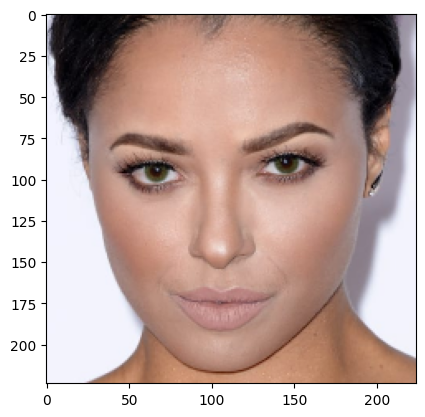

In [ ]:
# from the image that we've previously cropped with face detection bounding box
img = cv2.imread(examples[0])
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_face = extract_face(rgb)
plt.imshow(new_face);

To account for variations in a face image, we will augment the images as follows:
- Flip horizontally left/right (`filplr`)
- Rotate the image between -20 and 20 degrees to account for some head tilting.

Text(0.83, 0.08, '-20 degrees')

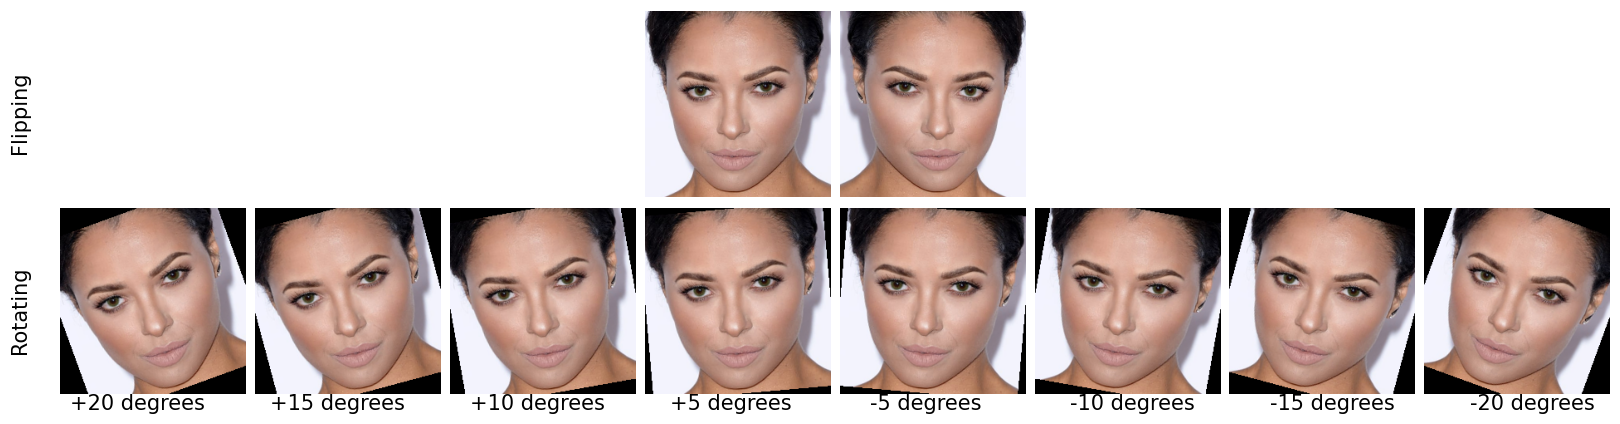

In [ ]:
# Augmenting the above image and plotting the augmented images in subplots below.

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=((8*2.5), (2*2.5)))
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax= ax.ravel()
for i in range(16):
    ax[i].axis('off')

# Original image.
ax[3].imshow(new_face)

# Augmented image: original image flipped laterally.
img_flip = np.fliplr(new_face)
ax[4].imshow(img_flip)

# Augmented image: original image with 5deg rotation.
img_rot_pos5 = ndimage.rotate(new_face, 5, reshape=False)
ax[11].imshow(img_rot_pos5)

# Augmented image: original image with 10deg rotation.
img_rot_pos10 = ndimage.rotate(new_face, 10, reshape=False)
ax[10].imshow(img_rot_pos10)

# Augmented image: original image with 15deg rotation.
img_rot_pos15 = ndimage.rotate(new_face, 15, reshape=False)
ax[9].imshow(img_rot_pos15)

# Augmented image: original image with 20deg rotation.
img_rot_pos20 = ndimage.rotate(new_face, 20, reshape=False)
ax[8].imshow(img_rot_pos20)

# Augmented image: original image with -5deg rotation.
img_rot_neg5 = ndimage.rotate(new_face, -5, reshape=False)
ax[12].imshow(img_rot_neg5)

# Augmented image: original image with -10deg rotation.
img_rot_neg10 = ndimage.rotate(new_face, -10, reshape=False)
ax[13].imshow(img_rot_neg10)

# Augmented image: original image with -15deg rotation.
img_rot_neg15 = ndimage.rotate(new_face, -15, reshape=False)
ax[14].imshow(img_rot_neg15)

# Augmented image: original image with -20deg rotation.
img_rot_neg20 = ndimage.rotate(new_face, -20, reshape=False)
ax[15].imshow(img_rot_neg20)

plt.figtext(x=0.1, y=0.60, s="Flipping", fontsize=15, rotation=90)
plt.figtext(x=0.1, y=0.20, s="Rotating", fontsize=15, rotation=90)
plt.figtext(x=0.13, y=0.08, s="+20 degrees", fontsize=15)
plt.figtext(x=0.23, y=0.08, s="+15 degrees", fontsize=15)
plt.figtext(x=0.33, y=0.08, s="+10 degrees", fontsize=15)
plt.figtext(x=0.43, y=0.08, s="+5 degrees", fontsize=15)
plt.figtext(x=0.53, y=0.08, s="-5 degrees", fontsize=15)
plt.figtext(x=0.63, y=0.08, s="-10 degrees", fontsize=15)
plt.figtext(x=0.73, y=0.08, s="-15 degrees", fontsize=15)
plt.figtext(x=0.83, y=0.08, s="-20 degrees", fontsize=15)

For modelling stage, we will use the following:
- Horizontal flip
- Rotation of +/- 20 degrees to account for head tilting, but beyond 20 degress would be an unlikely angle.


## Load in data files (RGB color)

In [ ]:
path = "/content/drive/MyDrive/CV Project/"
X_train = np.asarray(pickle.load(open(path + "X_train_r224.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_r224.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_r224.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_r224.pickle","rb")))

In [ ]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (510, 224, 224, 1)
y_train shape (510, 5)
--------------------
X_test shape (125, 224, 224, 1)
y_test shape (125, 5)


## Modelling with image augmentation

Epoch 1/40, Train Loss: 1.6111, Train Acc: 0.1980, Test Loss: 1.6095, Test Acc: 0.1840
Epoch 2/40, Train Loss: 1.6094, Train Acc: 0.2137, Test Loss: 1.6094, Test Acc: 0.2000
Epoch 3/40, Train Loss: 1.6088, Train Acc: 0.2176, Test Loss: 1.6084, Test Acc: 0.2000
Epoch 4/40, Train Loss: 1.6086, Train Acc: 0.2078, Test Loss: 1.6063, Test Acc: 0.2560
Epoch 5/40, Train Loss: 1.6056, Train Acc: 0.2373, Test Loss: 1.6006, Test Acc: 0.2800
Epoch 6/40, Train Loss: 1.5971, Train Acc: 0.2569, Test Loss: 1.6020, Test Acc: 0.1760
Epoch 7/40, Train Loss: 1.5957, Train Acc: 0.2392, Test Loss: 1.5912, Test Acc: 0.2880
Epoch 8/40, Train Loss: 1.5917, Train Acc: 0.2588, Test Loss: 1.5980, Test Acc: 0.2320
Epoch 9/40, Train Loss: 1.5859, Train Acc: 0.2784, Test Loss: 1.6036, Test Acc: 0.2000
Epoch 10/40, Train Loss: 1.5843, Train Acc: 0.2745, Test Loss: 1.6101, Test Acc: 0.1520
Epoch 11/40, Train Loss: 1.5781, Train Acc: 0.2549, Test Loss: 1.6082, Test Acc: 0.1840
Epoch 12/40, Train Loss: 1.5760, Train Ac

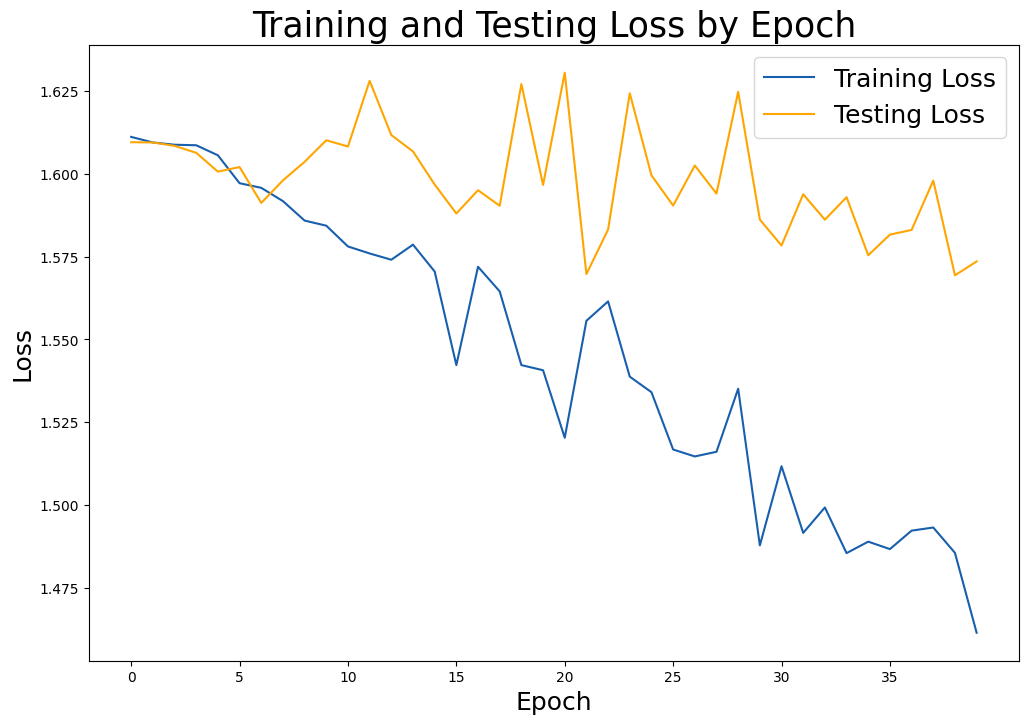

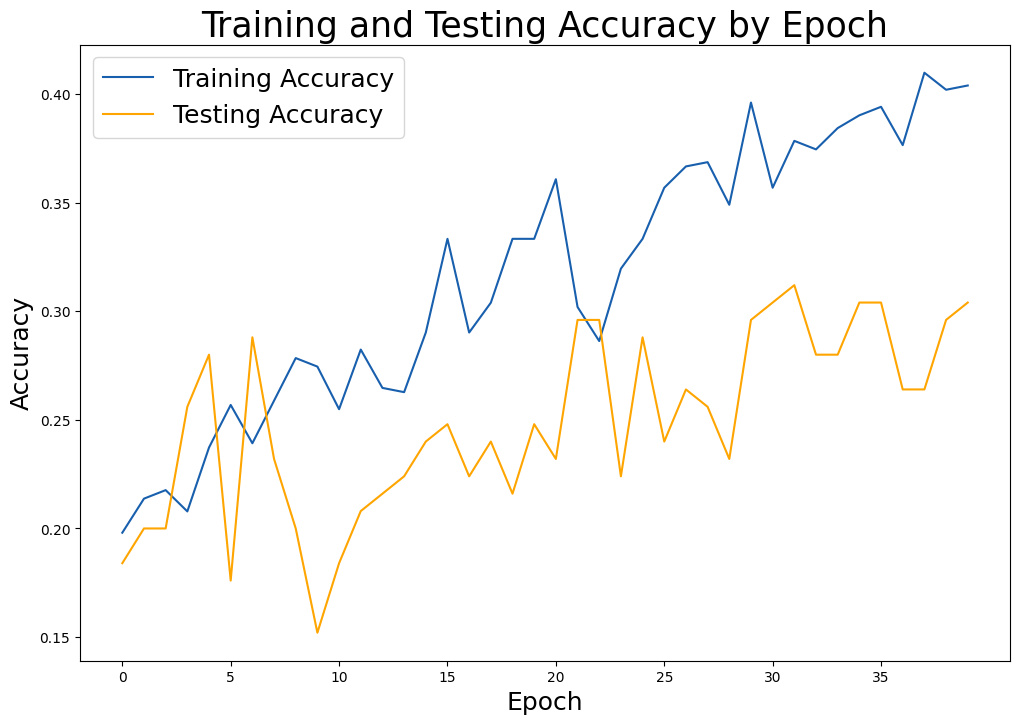

Normalized confusion matrix
[[0.52 0.24 0.04 0.2  0.  ]
 [0.52 0.28 0.   0.2  0.  ]
 [0.6  0.2  0.   0.2  0.  ]
 [0.24 0.12 0.   0.48 0.16]
 [0.28 0.04 0.   0.44 0.24]]


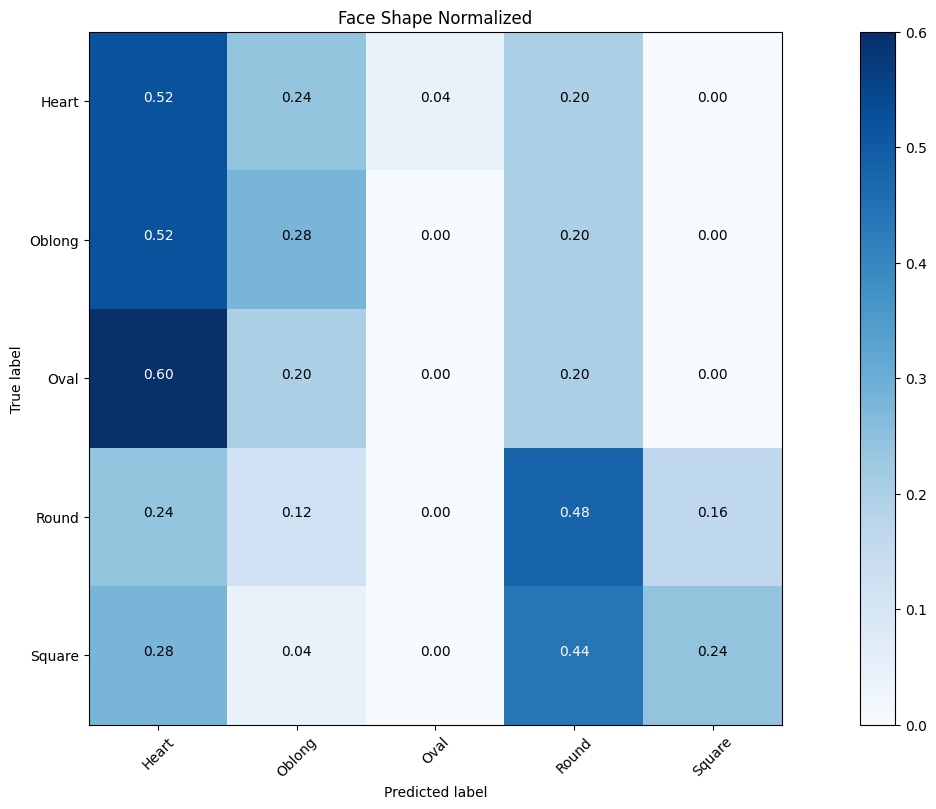

In [6]:


def show_img(num, img_array, title, ncols=1):
    '''Display images from an image array'''
    nrows = int(np.ceil(num/ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    fig.suptitle(title, size=20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)
    for i in range(num, nrows*ncols):
        ax[i].axis('off')

def crop_and_resize(image, target_w=224, target_h=224):
    '''Crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w, resize_h))
        crop_left = int((resize_w - target_w)/2)
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    elif input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w, resize_h))
        crop_top = int((resize_h - target_h)/4)
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    else:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

def extract_face(img, target_size=(224,224)):
    '''Extract face from image using MTCNN or fallback to cropping'''
    if detector is None:
        return crop_and_resize(img, target_size[0], target_size[1])

    try:
        results = detector.detect_faces(img)
        if not results:
            return crop_and_resize(img, target_size[0], target_size[1])

        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]

        adj_h = 10
        new_y1 = max(0, y1-adj_h)
        new_y2 = min(img.shape[0], y1+height+adj_h)
        new_height = new_y2 - new_y1

        adj_w = int((new_height-width)/2)
        new_x1 = max(0, x1-adj_w)
        new_x2 = min(img.shape[1], x2+adj_w)
        new_face = img[new_y1:new_y2, new_x1:new_x2]

    except Exception as e:
        print(f"Error in face detection: {e}")
        return crop_and_resize(img, target_size[0], target_size[1])

    return cv2.resize(new_face, target_size)

class FaceShapeDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        # Convert grayscale to RGB if needed
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        if self.transform:
            image = self.transform(image)

        return image, label

class FaceShapeModel(nn.Module):
    def __init__(self, input_channels=3):
        super(FaceShapeModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 32)  # Adjusted for 224x224 input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc2(x), dim=1)
        return x

# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Basic transform without augmentation for test data
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
path = "/content/drive/MyDrive/CV Project/"

X_train = np.asarray(pickle.load(open(path + "X_train_r224.pickle", "rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_r224.pickle", "rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_r224.pickle", "rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_r224.pickle", "rb")))

# Convert labels to class indices if they're one-hot encoded
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Create datasets
train_dataset = FaceShapeDataset(X_train, y_train, transform=augmentation_transform)
test_dataset = FaceShapeDataset(X_test, y_test, transform=basic_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceShapeModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 40
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plot results
def plot_results(train_metric, test_metric, metric_name, epochs):
    plt.figure(figsize=(12, 8))
    plt.plot(train_metric, label=f'Training {metric_name}', color='#185fad')
    plt.plot(test_metric, label=f'Testing {metric_name}', color='orange')
    plt.title(f'Training and Testing {metric_name} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(metric_name, fontsize=18)
    plt.xticks(range(0,epochs,5), range(0,epochs,5))
    plt.legend(fontsize=18)
    plt.show()

plot_results(train_losses, test_losses, 'Loss', epochs)
plot_results(train_accs, test_accs, 'Accuracy', epochs)

# Confusion matrix
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Face Shape Normalized')

# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/CV Project/save models/face_shape_model.pth')